# Proyecto: Engrasandonos las manos con datos

¡Bienvenidos al segundo proyecto de la carrera de Data Science de Acamica! 

En este proyecto vamos a seguir trabajando con el dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo en este caso es continuar con la limpieza de datos y avanzar en remover valores faltantes y remover outliers. Por otro lado, vamos a agregar nuevos atributos basados en los datos.

## Dataset: Propiedades en venta en Ciudad de Buenos Aires.

En este proyecto, trabajaremos con una muestra del conjunto de datos de propiedades en venta mencionado. En este dataset, cada fila es una propiedad en venta. A continuación vamos a describir los atributos que consideramos en esta muestra:

* id: id de la propiedad
* created_on: fecha en la que la propiedad ingresó al sitio
* operation: alquiler (rent) o venta (sell)
* property_type: tipo de propiedad (casa, departamento, ph, etcétera)
* place_with_parent_names: nombre del lugar donde se encuentra la propiedad según el publicador
* lat-lon: coordenadas concatenadas
* lat: latitud
* lon: longitud
* price: precio en la moneda especificada en currency
* currency: divisa en la que está expresada la publicación
* price_aprox_usd: precio aproximado en dólares estadounidenses
* surface_total_in_m2: superficie total (en metros cuadrados)
* surface_covered_in_m2: superficie cubierta (en metros cuadrados)
* price_usd_per_m2: precio por metro cuadrado en dólares (precio dólares / superficie)
* floor: número de piso (si corresponde)
* rooms: cantidad de ambientes
* expenses: expensas (si corresponde)
* barrio: barrio según cartografía oficial
* properati_url: url de la publicación en Properati

A continuación vamos a levantar el dataset para comenzar el procesamiento. Cabe destacar que en este caso ya fueron hechas las correcciones de coordenadas y superficies incorrectas que vimos en el proyecto anterior

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import impute

MAX_ROWS = 10
pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', 200)
 
sns.set_style("whitegrid")
sns.set_context("paper")

plt.rcParams['figure.figsize'] = (12,5)

In [2]:
path_dataset = "C:/Users/Macu/Desktop/acamica_data_science/entrega+2/dataset/datos_properati_limpios.csv"

df = pd.read_csv(path_dataset, parse_dates=['created_on'])

In [3]:
df.columns

Index(['created_on', 'property_type', 'place_name', 'place_with_parent_names',
       'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms',
       'expenses', 'properati_url', 'barrio'],
      dtype='object')

In [4]:
print("El dataset que vamos a trabajar aquí tiene {} observaciones".format(df.shape[0]))

El dataset que vamos a trabajar aquí tiene 13756 observaciones


Dado que ya lo trabajamos en el proyecto anterior, en este caso ya hemos filtrado observaciones para trabajar solo con casas (house), departamentos (apartment) y PH (PH).

### Outliers

Analicemos en primer lugar los valores extremos que puede haber en los precios y en las superficies. Esto nos va a ser útil para luego imputar usando medidas de tendencia central, como el promedio. 
Recordemos que las medidas de tendencia central pueden ser sensibles a outliers, por lo que la imputación de valores faltantes puede verse afectada

Una posible pregunta que surge es si conviene primero imputar faltantes y luego remover outliers, o lo contrario.  Cuando se imputa se modifica la distribución de los datos. Por eso, las cotas que utilicemos para definir los outliers se verán afectadas por este cambio y modificarán los resultados finales. Entonces comenzaremos quitando outliers.

Vamos a trabajar con `price_usd_per_m2`. Precios altos pueden corresponderse con grandes superficies, por lo que conviene analizar juntos ambos atributos. Veamos la distribución de los valores y un boxplot para comenzar a identificar los outliers.

**1) Utilizá** seaborn para hacer un `distplot` del precio por metro cuadrado. 

Deberás hacer un `drop` de los valores `NaN` de esta columna antes de graficar.

In [5]:
# Mostrá la figura en esta celda
df1 = df.copy()
df1 = df1.dropna(subset= ["price_usd_per_m2"])

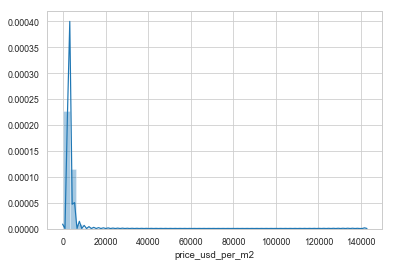

In [8]:
sns.distplot(df1["price_usd_per_m2"])

**2) Hacé** un `boxplot` de la columna `price_usd_per_m2`

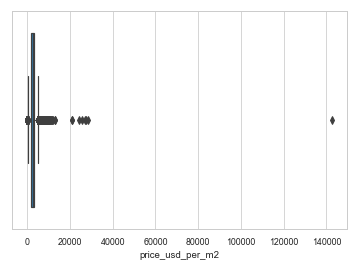

In [9]:
sns.boxplot(df1["price_usd_per_m2"])

¿A qué conclusión podemos llegar observando estas figuras?

**Responder**

Dado lo observado en los gráficos se puede ver que hay errores en el dataset, debido a que para trabajar con ph, casas y departamentos los terrenos son inmensos. 

Para confirmar la presencia de outliers vamos a utilizar los percentiles.

**3) Describir** la columna mostrando sus estadísticos

In [10]:
# Describir la columna en esta celda
df1.price_usd_per_m2.describe()

count     12973.000000
mean       2695.065767
std        1773.086831
min           0.958333
25%        1959.183673
50%        2510.204082
75%        3125.000000
max      142450.141026
Name: price_usd_per_m2, dtype: float64

Estamos ante la presencia de valores extremos en ambas puntas de la distribución. Vamos a aplicar la técnica del rango intercuartílico para limpiarlos.

Para obtener el rango tenemos que calcular la diferencia entre el tercer y el primer percentil. Luego en base a esto calcularemos los valores mínimos y máximos para definir qué observaciones serán descartadas.

**4) Aplicar la técnica del rango intercuartílico** para limpiar el precio por metro cuadrado. El resultado deberá ser un `dataframe` llamado `df_filtered` sin los outliers.

In [11]:
# Realizar el filtrado intercuartílico en esta celda
Q1 = df1.price_usd_per_m2.quantile(0.25)
Q3 = df1.price_usd_per_m2.quantile(0.75)
IQR = Q3 - Q1 
Umbral_Menor = Q1 - IQR* 1.5
Umbral_Mayor = Q3 + IQR* 1.5
print("IQR ", IQR)
print("Umbral_Menor ",Umbral_Menor)
print("Umbral_Mayor ",Umbral_Mayor)

IQR  1165.8163265306118
Umbral_Menor  210.45918367347053
Umbral_Mayor  4873.724489795917


In [12]:
df_filtered = df1[(df1["price_usd_per_m2"] >= Umbral_Menor) | (df1["price_usd_per_m2"] <= Umbral_Mayor)]

In [13]:
df_filtered.head()

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,barrio
0,2017-09-22,house,Palermo Viejo,|Argentina|Capital Federal|Palermo|Palermo Viejo|,-34.588953,-58.429882,2000000.0,312.0,NaN,6410.256410,NaN,NaN,NaN,https://www.properati.com.ar/2os_venta_casa_pa...,PALERMO
1,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.588912,-58.413494,340000.0,130.0,120.0,2615.384615,NaN,4.0,8000.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO
2,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.577033,-58.423368,222000.0,52.0,48.0,4269.230769,NaN,1.0,NaN,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO
3,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.595014,-58.427392,180000.0,70.0,70.0,2571.428571,NaN,NaN,3000.0,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO
4,2017-08-30,house,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.579354,-58.436449,1200000.0,532.0,334.0,2255.639098,NaN,6.0,NaN,https://www.properati.com.ar/1e1ve_venta_casa_...,PALERMO


In [14]:
print(df_filtered.price_usd_per_m2.max())
print(df_filtered.price_usd_per_m2.min())

142450.14102564106
0.9583333333333334


**5)** Volver a **plotear** con `distplot` y `boxplot` los precios sin los outliers y observá las diferencias con los anteriores ploteo.

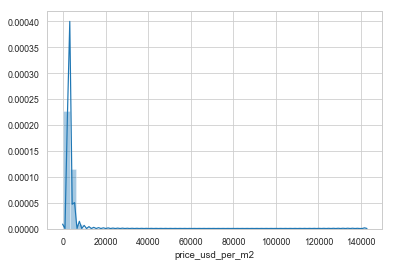

In [15]:
# Hacé el distplot 
sns.distplot(df_filtered["price_usd_per_m2"])

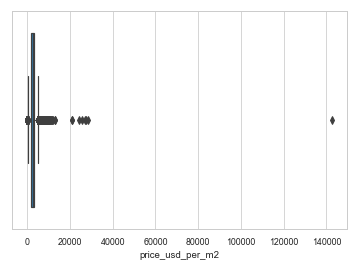

In [16]:
# Hacé el boxplot en esta celda
sns.boxplot(df_filtered["price_usd_per_m2"])

**6) Describir** nuevamente la columna mostrando sus estadísticos.

In [17]:
df_filtered["price_usd_per_m2"].describe()

count     12973.000000
mean       2695.065767
std        1773.086831
min           0.958333
25%        1959.183673
50%        2510.204082
75%        3125.000000
max      142450.141026
Name: price_usd_per_m2, dtype: float64

Vamos a seguir trabajando con el `dataframe` filtrado

In [18]:
#df = df_filtered

### Valores Faltantes

A diferencia del proyecto pasado, vamos a intentar imputar los valores faltantes para los atributos que consideramos importantes para el mercado inmobiliario. 

Estos atributos son los que informan **superficie (total o cubierta), cantidad de ambientes, precio y precio por metro cuadrado**. 

Veamos en primer lugar cuántos valores faltantes tiene cada atributo. Nos interesa verlo como un porcentaje en relación a la cantidad de observaciones. Si un atributo tiene un elevado porcentaje de faltantes, puede ser mejor no considerarlo en el análisis.

**7) Mostrar** cual es el porcentaje de valores faltantes para cada columna.

In [19]:
# Mostrá los valores faltantes en esta celda
porcentaje_null = ((df_filtered.isnull().sum() / len(df_filtered))*100).sort_values(ascending = False)
porcentaje_null

floor                      85.508364
expenses                   74.123179
rooms                      17.266631
surface_covered_in_m2       3.831034
barrio                      0.000000
                             ...    
lat                         0.000000
place_with_parent_names     0.000000
place_name                  0.000000
property_type               0.000000
created_on                  0.000000
Length: 15, dtype: float64

Podemos ver en los resultados que los atributos `floor` y `expenses` tienen un elevado porcentaje de faltantes.  Una opción sería descartar estas columnas en el análisis. 
Si elimináramos las observaciones (filas) asociadas a estos, perderíamos el 84.79% de los datos, mermando demasiado el conjunto de datos.

Otra opción sería por ejemplo considerar categorías como faltantes o no faltantes o en todo caso analizar si hay algún patrón para poder evitar quitarlos. 

Para avanzar con el proyecto, vamos a quitar esos atributos.

In [20]:
df_filtered = df_filtered.drop(['floor', 'expenses'], axis = 1)

Analicemos estrategias para imputar los valores faltantes para los atributos `rooms`, `surface_total_in_m2` y `surface_covered_in_m2`.

Como vimos en las actividades, entre las opciones que tenemos está la posibilidad de imputar por algún medida de tendencia central, como el caso de la media o la mediana. Vamos a avanzar en esa dirección.

**8) Imputar las observaciones faltantes** de la columna `surface_total_in_m2 ` y `surface_covered_in_m2` usando la **media**. 

`Scikit-learn` nos provee la clase `Imputer` que implementa las formas más comunes de imputación.

In [21]:
# Imputar los valores en esta celda
imp = impute.SimpleImputer(missing_values= np.nan, strategy='mean', fill_value=None) 

In [22]:
df_filtered["surface_total_in_m2"].mean()

146.53341555538427

In [23]:
total_imp = imp.fit_transform(df_filtered[["surface_total_in_m2"]]) 

In [24]:
np.isnan(total_imp).any()

False

In [25]:
df_filtered["surface_total_in_m2"] = total_imp

In [26]:
df_filtered["surface_total_in_m2"].isnull().sum()

0

In [27]:
df_filtered["surface_total_in_m2"].mean()

146.53341555538427

In [28]:
df_filtered["surface_covered_in_m2"].mean()

124.61261622314845

In [29]:
covered_imp= imp.fit_transform(df_filtered[["surface_covered_in_m2"]]) 

In [30]:
np.isnan(covered_imp).any()

False

In [31]:
df_filtered["surface_covered_in_m2"] = covered_imp

In [32]:
df_filtered["surface_covered_in_m2"].isnull().sum()

0

In [33]:
df_filtered["surface_covered_in_m2"].mean()

124.61261622314761

Una de las limitaciones que presenta este tipo de imputación es que provoca estimaciones sesgadas de la varianza. Esto impacta en los errores estandar y, por ende, en los tests estadístcos.

Este tipo de técnicas es útil cuando los valores son completamente al azar.

**9) Imputar las observaciones faltantes** de la columna `rooms` usando la **mediana**.

In [34]:
# Imputar con la mediana en esta celda
imp = impute.SimpleImputer(missing_values= np.nan, strategy='median', fill_value=None) 

In [35]:
df_filtered["rooms"].median()

3.0

In [36]:
rooms_imp= imp.fit_transform(df_filtered[["rooms"]]) 

In [37]:
np.isnan(rooms_imp).any()

False

In [38]:
df_filtered["rooms"] = rooms_imp

In [39]:
df_filtered["rooms"].isnull().sum()

0

In [40]:
df_filtered["rooms"].median()

3.0

### Variables binarias

#### Generar variables binarias para el atributo `property_type`.

Hay que tener en cuenta en este caso que el atributo es categórico.

Para hacerlo usando scikit-learn, por como vienen dados los valores (en formato string), primero conviene convertirlos en numéricos. Para esto usamos `LabelEncoder`.

**10) Convertí** las variables de `property_type` utilizando `LabelEncoder`

In [41]:
# Utilizá LabelEncoder en esta celda
df_filtered.property_type.unique()

array(['house', 'apartment', 'PH'], dtype=object)

In [42]:
le_proptype = preprocessing.LabelEncoder()

In [43]:
le_proptype.fit_transform(df_filtered['property_type'])

array([2, 1, 1, ..., 2, 1, 1])

**11) Mostrar** las clases del `LabelEncoder`:

In [44]:
# Mostrar la propiedad classes_ del LabelEncoder que creaste
property_type_le = le_proptype.fit_transform(df_filtered['property_type'])

In [45]:
le_proptype.classes_

array(['PH', 'apartment', 'house'], dtype=object)

In [46]:
df_filtered['property_type_le'] = property_type_le

In [47]:
df_filtered.head()

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,properati_url,barrio,property_type_le
0,2017-09-22,house,Palermo Viejo,|Argentina|Capital Federal|Palermo|Palermo Viejo|,-34.588953,-58.429882,2000000.0,312.0,124.612616,6410.256410,3.0,https://www.properati.com.ar/2os_venta_casa_pa...,PALERMO,2
1,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.588912,-58.413494,340000.0,130.0,120.000000,2615.384615,4.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO,1
2,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.577033,-58.423368,222000.0,52.0,48.000000,4269.230769,1.0,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO,1
3,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.595014,-58.427392,180000.0,70.0,70.000000,2571.428571,3.0,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO,1
4,2017-08-30,house,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.579354,-58.436449,1200000.0,532.0,334.000000,2255.639098,6.0,https://www.properati.com.ar/1e1ve_venta_casa_...,PALERMO,2


Luego con `OneHotEncoder` obtenemos las categorías expresadas como **variables binarias**. 

**12) Aplicar** `OneHotEncoder` sobre las variables categóricas para crear un dataframe `categoricals_df`

In [48]:
# Utilizá OneHotEncoder en esta celda 
ohenc = preprocessing.OneHotEncoder(sparse = False)

In [49]:
np.shape(property_type_le)[0]

12973

In [50]:
property_type_le = np.reshape(property_type_le, (np.shape(property_type_le)[0],1))

In [51]:
onehot_encoded = ohenc.fit_transform(property_type_le)

C:\Users\Macu\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [52]:
onehot_encoded

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [53]:
categoricals_df = pd.DataFrame(onehot_encoded, index = df_filtered.index , columns = le_proptype.classes_)

Unimos el nuevo dataframe `categorical_df` con el `dataframe` original `df`. Para esto, necesitamos que tengan el mismo índice.

In [54]:
categoricals_df = categoricals_df.set_index(df_filtered.index)
df_filtered = pd.concat([df_filtered, categoricals_df], axis=1)
df_filtered.head()

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,properati_url,barrio,property_type_le,PH,apartment,house
0,2017-09-22,house,Palermo Viejo,|Argentina|Capital Federal|Palermo|Palermo Viejo|,-34.588953,-58.429882,2000000.0,312.0,124.612616,6410.256410,3.0,https://www.properati.com.ar/2os_venta_casa_pa...,PALERMO,2,0.0,0.0,1.0
1,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.588912,-58.413494,340000.0,130.0,120.000000,2615.384615,4.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO,1,0.0,1.0,0.0
2,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.577033,-58.423368,222000.0,52.0,48.000000,4269.230769,1.0,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO,1,0.0,1.0,0.0
3,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.595014,-58.427392,180000.0,70.0,70.000000,2571.428571,3.0,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO,1,0.0,1.0,0.0
4,2017-08-30,house,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.579354,-58.436449,1200000.0,532.0,334.000000,2255.639098,6.0,https://www.properati.com.ar/1e1ve_venta_casa_...,PALERMO,2,0.0,0.0,1.0


### Variables calculadas

__Calcular el precio por metro cuadrado (precio/superficie total). Llamar a este atributo `price_m2`.__

Hay que tener cuidado en esta parte respecto de dividir por cero. Para ello, armemos una función de división que contemple eso.

El hecho de crear una columna nueva y no imputar los faltantes es simplemente una decisión. Cuando veamos modelos predictivos, vamos a poder cuantificar el costo de las decisiones que tomemos en términos de performance del modelo.

In [55]:
def custom_division(x, y):
    if y > 0:
        res = x / y
    else:
        res = 0
    return res

df_filtered['price_m2'] = df_filtered.apply(lambda x: custom_division(x['price_aprox_usd'], x['surface_total_in_m2']), axis = 1)
df_filtered.drop(['price_usd_per_m2'], axis=1, inplace=True)

__Verificar que ya no quedan atributos con valores faltantes__

In [56]:
# Creamos un dataset con los porcentajes de nulos
df_faltantes = pd.DataFrame(df_filtered.isnull().sum() / df_filtered.shape[0], columns=['Porcentaje nulos'])
# Solo mostramos los que tengan valores nulos. Si el porcentaje es 0 no se muestra
df_faltantes.loc[~(df_faltantes==0).all(axis=1)]

,Porcentaje nulos


In [57]:
print("El dataset final luego del procesamiento tiene {} observaciones".format(df_filtered.shape[0]))

El dataset final luego del procesamiento tiene 12973 observaciones


De este modo, hemos limpiado valores extremos e imputado valores nulos. El costo de esto fue la pérdida de 685 observaciones, 5% de la cantidad original de filas.